#### Workshop Description
Understanding the questions posed by instructors and students alike plays an important role in the development of educational technology applications. In this intermediate level workshop, you will learn to apply NLP to one piece of this real-world problem by building a model to predict the type of answer (e.g. entity, description, number, etc.) a question elicits. Specifically, you will learn to:
1. Perform preprocessing, normalization, and exploratory analysis on a question dataset,
2. Identify salient linguistic features of natural language questions, and
3. Experiment with different feature sets and models to predict the answer type.
4. Use powerful pretrained language models to create dense sentence representations and apply deep learning models to text classification.

The concepts will be taught using popular NLP and ML packages like SpaCy, Scikit Learn, and Tensorflow.

This workshop assumes familiarity with Jupyter notebooks and the basics of scientific packages like numPy and sciPy. We also assume some basic knowledge of machine learning and deep learning techniques like CNNs, LSTMs, etc. Reference materials will be provided to gain a better understanding of these techniques for interested attendees.
***


# Deep Representation Learning to classify TREC question-classification text

**Overview:** 
In this session we'll try to solve the TREC question-classification problem by using a few popular Deep Learning Algorithms.
Concretely, we will use pre-trained Language Models to generate **representations(Embeddings)** for our input data and then classify these representations using a shallow neural network.
We will examine the network architectures of **Universal Sentence Encoder(USE)** and **Bidirectional Encoder Representation from Transformers(BERT)** and touch upon the pros and cons of these architectures in classifying TREC question-classification data.

### What you'll learn:
- How to use **Keras** for Text classification
- How to generate representations using pre-trained **Universal Sentence Encoder: USE**
- How to tune and evaluate Deep Learning models 
- How to use **Tensorflow** for Text classification
- How to use pre-trained Language Model **Bidirectional Encoder Representation from Transformers: BERT** for Text classification

**Note:** We will be using the same dataset as the previous 2 sessions. Notebook links to the previous session are available **INSERT LINK**

### Word Represenations:
![dep_nobj-1](images/Word2Vec.png)

### Utility Functions
The following two utility functions provide functionality that can be used across different models to inspect training metrics and performance. These will be used at a later point in time.

In [85]:
#Matplotlib Plotting Import
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Function to plot training accuracy/loss, validation accuracy/loss.
    
    Parameters
    ----------
    history: 
        Keras training history object. See: https://keras.io/callbacks/#history
    
    Returns
    -------
    
    """
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [86]:
import numpy as np

#Keras Imports: USE Embedding Classification
from keras.layers import Dense, Input, Dropout
from keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Sklearn Utility Imports
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

def generate_classification_report(model_path, label_encoder, test_features, test_labels, class_names=None):
    """
    Function to generate SKLearn based multi class classification report
    
    Parameters
    ----------
    model_path: Path to trained model.
    label_encoder: Encoder used during label transformation
    test_features: Features for test.
    test_labels: Ground truth labels
    class_names: Class names for the true and pred integer values
    
    Returns
    -------
    dict: sklearn.metrics.classification_report
        MultiClass Classification Report.
    """
    
    # Load pre-trained model
    model = load_model(model_path)
    
    # Predict labels for test features
    preds = model.predict(test_features)
    
    # Since the model is trained to return a set of probabilities across the label set, 
    # we'll have to find the index of label set with the highest probability score.
    preds_index = np.argmax(preds, axis=1)
    
    # Converting the predicted index into the original TREC based label
    preds_labels = label_encoder.inverse_transform(preds_index)
    
    return classification_report(test_labels, preds_labels, target_names=label_encoder.classes_)

### Download Data

First let's download the train and test data from Xin Li, Dan Roth, Learning Question Classifiers. COLING'02, Aug., 2002.
    <https://cogcomp.seas.upenn.edu/Data/QA/QC/">https://cogcomp.seas.upenn.edu/Data/QA/QC/>
    
We will store these data in Pandas DataFrames (and write them as .csv files) containing the following columns:
- *question*: The question text
- *processed_question*: The question as a SpaCy Doc object
- *coarse_label*: The coarse-grained label (6 classes)
- *label*: The fine-grained label

Recall that in Module 1, we found that some questions were duplicated. Let's remove those now.

In [87]:
import os
import pandas as pd
from download_data import main as download_trec_data

path_to_train = os.path.join("data", "train.csv")
path_to_test = os.path.join("data", "test.csv")

train_df = pd.read_csv(os.path.join("data", "train.csv"))
test_df = pd.read_csv(os.path.join("data", "test.csv"))

#
# Dedupe from python module.
#
train_df = train_df.drop_duplicates("question")
test_df = test_df.drop_duplicates('question')

## Universal Sentence Encoder
<u>Reference Paper</u>: https://arxiv.org/abs/1803.11175<br>
<u>Announcement</u>: https://ai.googleblog.com/2018/05/advances-in-semantic-textual-similarity.html<br><br>
**Universal Sentence Encoder (USE)** is a versatile sentence embedding model that convert sentences into vector representations. These vectors capture rich semantic information that can be used to train classifiers for a broad range of downstream tasks.

![dep_nobj-1](images/USE.png)

Note: USE can work on small multi sentence paragraphs.


### High level steps for classifying text using pre-trained USE model: 
- Download Pre-trained USE Model from Tensorflow HUB<br>
- Extract USE Repesentations for both train and test sets<br>
- Define a the classification network architecture<br>
- Start Training


### Data Prep for USE Q&A classification

In [88]:
import re
def pre_process_text(input_text):
    """
    Function to normalize text by applying NLP tranformations.
    
    Parameters
    ----------
    input_text: String 
        Question text from the input sample
        
    Returns
    -------
    String
        pre-processed version of input string
    """
    #Exercise: build multiple models based on diferrent pre-processing techniques.
    #Un-Comment the below line to see if the model performance improves by introducing additional 
    #input_text = re.sub('[^A-Za-z0-9 ,\?\'\"-._\+\!/\`@=;:]+', '', input_text)
    return input_text.lower()

##### Extract the raw question text and labels from the training and test dataframes:

In [89]:
features_train = train_df['question'].to_list()
features_test  = test_df['question'].to_list()
labels_train   = train_df['coarse_label'].to_list()
labels_test    = test_df['coarse_label'].to_list()

##### Pre-Process the text used for training and test

In [90]:
# Pre-Process the text used for training and test
features_train_processed = list(map(lambda x:pre_process_text(x), features_train))
features_test_processed = list(map(lambda x:pre_process_text(x), features_test))

##### The labels for the training and test set are in a string format (eg: ABBR, DESC etc). These labels need to be converted into a numerical set using [Scikit Learn's Label Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [91]:
# Pre-Process labels for training
label_encoder = preprocessing.LabelEncoder()
labels_train_tranformed = label_encoder.fit_transform(labels_train)
labels_train_categorical = to_categorical(np.asarray(labels_train_tranformed))
# Note: We do not have to "fit" the label encoder for the test set since they already have been fit on the trainset
labels_test_transformed = label_encoder.transform(labels_test)
labels_test_categorical = to_categorical(np.asarray(labels_test_transformed))

##### Download and load the pre-trained Universal Sentence Encoder from Tensorflow Hub

In [92]:
#Tensorflow Imports
import tensorflow as tf
import tensorflow_hub as hub

pre_trained_use_embed_model = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

##### Generate sentence/phrase representations of the training and test text data using the above downloaded USE model

In [93]:
embeddings_features_train = []
embeddings_features_test = []
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    embeddings_features_train.append(session.run(pre_trained_use_embed_model(features_train_processed)))
    embeddings_features_test.append(session.run(pre_trained_use_embed_model(features_test_processed)))

I1020 23:56:27.558945 139704171878208 saver.py:1499] Saver not created because there are no variables in the graph to restore
I1020 23:56:33.227357 139704171878208 saver.py:1499] Saver not created because there are no variables in the graph to restore


In [94]:
# Inspect the shape of the input embeddings
question_embeddings_train = embeddings_features_train[0]
question_embeddings_test = embeddings_features_test[0]

In [95]:
# Inspect the shape of the input embeddings
question_embeddings_train.shape[1]

512

### Model Definition for USE Q&A classification

We will use the [Keras Functional API Guide](https://keras.io/getting-started/functional-api-guide/#first-example-a-densely-connected-network) to build and train the USE Q&A classifier network.

In [96]:
class QNAClassifier():
    """
    Q&A classifier class using Keras framework
    """
    
    def __init__(self, experiment_name):
        """
        Init function
        
        Parameters
        ----------
        experiment_name: String
            Name of the experiment. This will be used to name the model checkpoints.
            
        """
        
        #Exercise: Modify the below hyper parameters to create variations of the USE Q&A classifier model.
        self.patience = 10
        self.epochs = 100
        self.batch_size = 64
        
        self.experiment_name = experiment_name
        self.output_dir = 'models'
        self.class_count = 6
        self.model = None
        
        # Creating an output directory for the generated models.
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    
    def train_vanilla_nn(self, embeddings_train, labels_train, embeddings_test, labels_test):
        """
        Simple Feed forward neural network with 1 Dense layer to classify Q&A embeddings.
        
        Parameters
        ----------
        embeddings_train: Numpy Array
            USE embedding repesentation of the training set.
            
        labels_train: Numpy Array
            Categorical encoded labels for the training set.
            
        embeddings_test: Numpy Array
            USE embedding repesentation of the test set.
            
        labels_test: Numpy Array
            Categorical encoded labels for the test set.
            
        Returns
        -------
        Keras history object
            See: https://keras.io/callbacks/#history
        
        """
        
        # Network Architecture: Input Layer(Embeddings)-> Dense Layer -> Softmax layer
        # Exercise: Change the size of the hidden layer and the activation unit.
        embedding_inputs = Input(shape=(embeddings_train.shape[1],))
        x = Dense(256, activation='relu')(embedding_inputs)
        predictions = Dense(self.class_count, activation='softmax')(x)
        
        self.model = Model(inputs=embedding_inputs, outputs=predictions)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        
        # Keras Callbacks
        early_stopping = EarlyStopping(monitor='val_acc', patience=self.patience)
        model_filename = self.output_dir + "/" + self.experiment_name
        checkpoint = ModelCheckpoint(model_filename + '.{epoch:03d}-{val_acc:.4f}.hdf5',
                                     monitor='val_acc', verbose=1,
                                     save_best_only=True, mode='auto')
        
        # Start Training
        training_history = self.model.fit(embeddings_train, labels_train, 
                                          validation_data = (embeddings_test, labels_test),
                                          epochs= self.epochs,
                                          batch_size=self.batch_size,
                                          callbacks=[checkpoint, early_stopping])
        
        return training_history
    
    def train_vanilla_nn_cross_validated(self, embeddings_train, labels_train, embeddings_test, labels_test):
        """
        K-Fold Cross validated simple Feed forward neural network with 1 Dense layer to classify Q&A embeddings.
        
        Parameters
        ----------
        embeddings_train: Numpy Array
            USE embedding repesentation of the training set.
            
        labels_train: Numpy Array
            Categorical encoded labels for the training set.
            
        embeddings_test: Numpy Array
            USE embedding repesentation of the test set.
            
        labels_test: Numpy Array
            Categorical encoded labels for the test set.
            
        Returns
        -------
        list of training history objects
            Keras training history object. See: https://keras.io/callbacks/#history
            
        """

        # Network Architecture: Input Layer(Embeddings)-> Dense Layer -> Softmax layer
        # Exercise: Change the size of the hidden layer and the activation unit.
        embedding_inputs = Input(shape=(embeddings_train.shape[1],))
        x = Dense(64, activation='relu')(embedding_inputs)
        predictions = Dense(self.class_count, activation='softmax')(x)
        
        self.model = Model(inputs=embedding_inputs, outputs=predictions)
        self.model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
        
        early_stopping = EarlyStopping(monitor='val_acc', patience=self.patience)
        
        training_histories = []
        counter = 0
        
        #Exercise: Experiment with different number of splits.
        kf = KFold(n_splits=3, random_state=42, shuffle=False)
        for train_index, test_index in kf.split(embeddings_train):
            
            X_train, X_test = embeddings_train[train_index], embeddings_train[test_index]
            y_train, y_test = labels_train[train_index], labels_train[test_index]
            
            model_filename = self.output_dir + "/" + self.experiment_name + "_fold{}".format(counter)
            checkpoint = ModelCheckpoint(model_filename + '.{epoch:03d}-{val_acc:.4f}.hdf5',
                                         monitor='val_acc', verbose=1,
                                         save_best_only=True, mode='auto')
        
            # Start Training
            training_history = self.model.fit(X_train, y_train, 
                                              validation_data = (X_test, y_test),
                                              epochs= self.epochs,
                                              batch_size=self.batch_size,
                                              #Exercise: Add Tensorboard here
                                              callbacks=[checkpoint, early_stopping])
            
            print("-----------------------------\n")
            print("KSplit {} training complete\n".format(counter))
            print("-----------------------------\n")
            
            counter += 1
            
            training_histories.append(training_history)
        
        return training_histories
    
    def train_tuned_nn(self, embeddings_train, labels_train, embeddings_test, labels_test):
        
        """
        Tuned Feed forward neural network with 1 Dense layer to classify Q&A embeddings.
        
        Parameters
        ----------
        embeddings_train: Numpy Array
            USE embedding repesentation of the training set.
            
        labels_train: Numpy Array
            Categorical encoded labels for the training set.
            
        embeddings_test: Numpy Array
            USE embedding repesentation of the test set.
            
        labels_test: Numpy Array
            Categorical encoded labels for the test set.
            
        Returns
        -------
        Keras history object
            See: https://keras.io/callbacks/#history
        
        """
        embedding_inputs = Input(shape=(embeddings_train.shape[1],))
        x = Dense(128, activation='relu')(embedding_inputs)
        # Added dropouts for regularization
        # Exercise: Change the value of dropouts.
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu')(x)
        predictions = Dense(self.class_count, activation='softmax')(x)
        
        model = Model(inputs=embedding_inputs, outputs=predictions)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        
        # Keras Callbacks
        early_stopping = EarlyStopping(monitor='val_acc', patience=self.patience)
        model_filename = self.output_dir + "/" + self.experiment_name
        checkpoint = ModelCheckpoint(model_filename + '.{epoch:03d}-{val_acc:.4f}.hdf5',
                                     monitor='val_acc', verbose=1,
                                     save_best_only=True, mode='auto')
        
        
        # Start Training
        training_history = model.fit(embeddings_train, labels_train, 
                                     validation_data = (embeddings_test, labels_test),
                                     epochs= self.epochs,
                                     batch_size=self.batch_size,
                                     #Exercise: Add Tensorboard here
                                     callbacks=[checkpoint, early_stopping])
        
        return training_history

##### Train Vanilla Neural Network with Pre-trained USE Embeddings

In [97]:
# Train Vanilla Neural Network with Pre-trained USE Embeddings
use_embedding_classifier = QNAClassifier("USE_Embedding_Model")
use_embedding_training_history = use_embedding_classifier.train_vanilla_nn(question_embeddings_train, labels_train_categorical,
                                                                          question_embeddings_test, labels_test_categorical)

Train on 5381 samples, validate on 500 samples
Epoch 1/100
5381/5381 [==============================] - 11s 2ms/step - loss: 1.0667 - acc: 0.7045 - val_loss: 0.5248 - val_acc: 0.8560

Epoch 00001: val_acc improved from -inf to 0.85600, saving model to models/USE_Embedding_Model.001-0.8560.hdf5
Epoch 2/100
5381/5381 [==============================] - 0s 40us/step - loss: 0.5500 - acc: 0.8106 - val_loss: 0.3804 - val_acc: 0.8680

Epoch 00002: val_acc improved from 0.85600 to 0.86800, saving model to models/USE_Embedding_Model.002-0.8680.hdf5
Epoch 3/100
5381/5381 [==============================] - 0s 39us/step - loss: 0.4652 - acc: 0.8318 - val_loss: 0.3585 - val_acc: 0.8700

Epoch 00003: val_acc improved from 0.86800 to 0.87000, saving model to models/USE_Embedding_Model.003-0.8700.hdf5
Epoch 4/100
5381/5381 [==============================] - 0s 39us/step - loss: 0.4277 - acc: 0.8441 - val_loss: 0.3226 - val_acc: 0.8900

Epoch 00004: val_acc improved from 0.87000 to 0.89000, saving mode

##### Plot training history of above Vanilla Neural Network with Pre-trained USE Embeddings

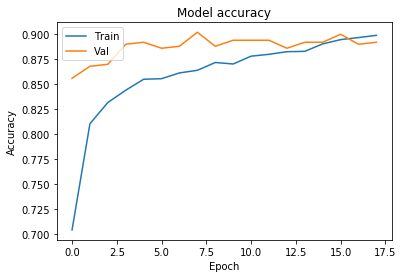

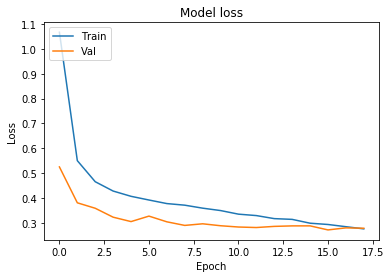

In [98]:
plot_training_history(use_embedding_training_history)

##### Train Cross Validated Vanilla Neural Network with Pre-trained USE Embeddings

In [99]:
# Train Cross Validated Vanilla Neural Network with Pre-trained USE Embeddings
use_embedding_classifier = QNAClassifier("USE_Embedding_CV_Model")
use_embedding_training_history = use_embedding_classifier.train_vanilla_nn_cross_validated(question_embeddings_train, labels_train_categorical,
                                                                                           question_embeddings_test, labels_test_categorical)

Train on 3587 samples, validate on 1794 samples
Epoch 1/100
3587/3587 [==============================] - 11s 3ms/step - loss: 1.3899 - acc: 0.5980 - val_loss: 1.0858 - val_acc: 0.7179

Epoch 00001: val_acc improved from -inf to 0.71795, saving model to models/USE_Embedding_CV_Model_fold0.001-0.7179.hdf5
Epoch 2/100
3587/3587 [==============================] - 0s 31us/step - loss: 0.9106 - acc: 0.7628 - val_loss: 0.7892 - val_acc: 0.7670

Epoch 00002: val_acc improved from 0.71795 to 0.76700, saving model to models/USE_Embedding_CV_Model_fold0.002-0.7670.hdf5
Epoch 3/100
3587/3587 [==============================] - 0s 30us/step - loss: 0.6956 - acc: 0.7937 - val_loss: 0.6555 - val_acc: 0.7893

Epoch 00003: val_acc improved from 0.76700 to 0.78930, saving model to models/USE_Embedding_CV_Model_fold0.003-0.7893.hdf5
Epoch 4/100
3587/3587 [==============================] - 0s 30us/step - loss: 0.5867 - acc: 0.8127 - val_loss: 0.5802 - val_acc: 0.8016

Epoch 00004: val_acc improved from 0.7

3587/3587 [==============================] - 0s 31us/step - loss: 0.3396 - acc: 0.8729 - val_loss: 0.3323 - val_acc: 0.8835

Epoch 00005: val_acc did not improve from 0.89186
Epoch 6/100
3587/3587 [==============================] - 0s 31us/step - loss: 0.3317 - acc: 0.8796 - val_loss: 0.3346 - val_acc: 0.8807

Epoch 00006: val_acc did not improve from 0.89186
Epoch 7/100
3587/3587 [==============================] - 0s 30us/step - loss: 0.3283 - acc: 0.8768 - val_loss: 0.3390 - val_acc: 0.8807

Epoch 00007: val_acc did not improve from 0.89186
Epoch 8/100
3587/3587 [==============================] - 0s 30us/step - loss: 0.3235 - acc: 0.8826 - val_loss: 0.3476 - val_acc: 0.8763

Epoch 00008: val_acc did not improve from 0.89186
Epoch 9/100
3587/3587 [==============================] - 0s 29us/step - loss: 0.3194 - acc: 0.8812 - val_loss: 0.3519 - val_acc: 0.8746

Epoch 00009: val_acc did not improve from 0.89186
Epoch 10/100
3587/3587 [==============================] - 0s 30us/step - loss

##### Train Tuned Neural Network with Pre-trained USE Embeddings

In [100]:
# Train Tuned Neural Network with Pre-trained USE Embeddings
use_embedding_tuned_classifier = QNAClassifier("USE_Embedding_Tuned_Model")
use_embedding_tuned_training_history = use_embedding_tuned_classifier.train_tuned_nn(question_embeddings_train, labels_train_categorical,
                                                                          question_embeddings_test, labels_test_categorical)

Train on 5381 samples, validate on 500 samples
Epoch 1/100
5381/5381 [==============================] - 12s 2ms/step - loss: 1.1910 - acc: 0.5774 - val_loss: 0.4969 - val_acc: 0.8540

Epoch 00001: val_acc improved from -inf to 0.85400, saving model to models/USE_Embedding_Tuned_Model.001-0.8540.hdf5
Epoch 2/100
5381/5381 [==============================] - 0s 37us/step - loss: 0.6157 - acc: 0.7837 - val_loss: 0.4012 - val_acc: 0.8700

Epoch 00002: val_acc improved from 0.85400 to 0.87000, saving model to models/USE_Embedding_Tuned_Model.002-0.8700.hdf5
Epoch 3/100
5381/5381 [==============================] - 0s 37us/step - loss: 0.5278 - acc: 0.8160 - val_loss: 0.3442 - val_acc: 0.8740

Epoch 00003: val_acc improved from 0.87000 to 0.87400, saving model to models/USE_Embedding_Tuned_Model.003-0.8740.hdf5
Epoch 4/100
5381/5381 [==============================] - 0s 37us/step - loss: 0.4952 - acc: 0.8175 - val_loss: 0.3164 - val_acc: 0.8840

Epoch 00004: val_acc improved from 0.87400 to 0.

##### Plot training history of above Tuned Neural Network with Pre-trained USE Embeddings

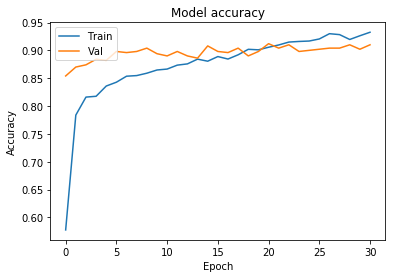

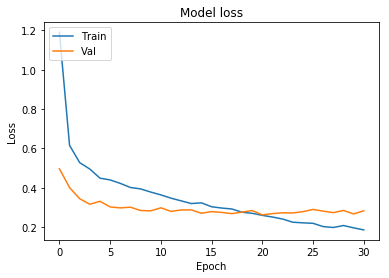

In [101]:
plot_training_history(use_embedding_tuned_training_history)

##### Plot the test classification metrics for the above Tuned Neural Network with Pre-trained USE Embeddings

In [102]:
# Note: Please use the appropriate model path corresponding to your training step.
print(generate_classification_report(model_path = 'models/USE_Embedding_Tuned_Model.011-0.9140.hdf5', 
                                     label_encoder = label_encoder,
                                     test_features = question_embeddings_test,
                                     test_labels = labels_test))

              precision    recall  f1-score   support

        ABBR       1.00      0.89      0.94         9
        DESC       0.91      0.91      0.91       138
        ENTY       0.83      0.82      0.82        94
         HUM       0.94      0.97      0.95        65
         LOC       0.97      0.90      0.94        81
         NUM       0.93      0.97      0.95       113

    accuracy                           0.91       500
   macro avg       0.93      0.91      0.92       500
weighted avg       0.91      0.91      0.91       500



***

## BERT: Bidirectional Encoder Representation from Transformers 
<u>Refrence Paper</u>: https://arxiv.org/abs/1810.04805<br>
<u>Announcement</u>: https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html

**BERT** is the current state of the art Language Model and is designed by pre-training deep bidirectional representations from unlabeled(Wikipedia)text by jointly conditioning on both left and right context in all layers.
BERT’s model architecture is a multi-layer/stacked set of bidirectional Transformers with the following 2 variants:
**BERTBASE** (L=12, H=768, A=12, Total Parameters=110M) and **BERTLARGE** (L=24, H=1024, A=16, Total Parameters=340M).

![dep_nobj-1](images/BERT.png)


<h3>Data Prep for BERT Q&A classification</h3>

Since BERT is a pre-trained Langauage Model, fine-tuning tasks using BERT is expected to have the same input format of data as that of BERT's training. In a nutshell, we'll have to apply the following transformations to our input text to conform to BERT's fine tuning input expectation.
    
- Lowercase our text (if we're using a BERT lowercase model)<br>
- Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])<br>
- Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])<br>
- Map our words to indexes using a vocab file that BERT provides<br>
- Add special "CLS" and "SEP" tokens for NextSentenceIdentication (see the Section 3 https://arxiv.org/pdf/1810.04805.pdf)<br>
- Append "index" and "segment" tokens to each input (see the Section 3 https://arxiv.org/pdf/1810.04805.pdf)<br>


In [103]:
#BERT Imports: BERT Classification
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

##### Fortunately, there are multiple libraries that'll trannsform our raw Question text to a format that BERT understands
**bert.run_classifier.InputExample** is a data structure that will store the tranformed Quesstion text into BERT Input format. The below lambda section is only initializing these BERT Input format data structures.

In [104]:
train_InputSamples = list(map(lambda x,y: bert.run_classifier.InputExample(guid=None, text_a=x, text_b=None, label=y),
                              features_train, labels_train))
test_InputSamples = list(map(lambda x,y: bert.run_classifier.InputExample(guid=None, text_a=x, text_b=None, label=y),
                              features_test, labels_test))

##### Download the pre-trained BERT base model and load up the BERT tokenizers to operate on our transformed Question text

In [105]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
tf.logging.set_verbosity(tf.logging.INFO)

def create_tokenizer_from_hub_module():
    """
    Load the pre-trained BERT model and extract the vocab file and tokenizer from TF HUB

    Returns
    -------
    BERT tokenizer object: bert.tokenization.FullTokenizer
        See: https://github.com/google-research/bert/blob/master/tokenization.py
        
    """

    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                                  tokenization_info["do_lower_case"]])

    return bert.tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

I1020 23:58:37.155352 139704171878208 saver.py:1499] Saver not created because there are no variables in the graph to restore


##### Time to run the pre-trained BERT tokenizer on our input Question text

In [106]:
# This is the max length of tokens in our Question text dataset
# Exercise: Modify this MAX_SEQ_LENGTH value to see how it affects the training process
MAX_SEQ_LENGTH = 20
label_list = list(set(labels_train))

train_features = bert.run_classifier.convert_examples_to_features(train_InputSamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputSamples, label_list, MAX_SEQ_LENGTH, tokenizer)

I1020 23:58:37.776691 139704171878208 run_classifier.py:774] Writing example 0 of 5381
I1020 23:58:37.777919 139704171878208 run_classifier.py:461] *** Example ***
I1020 23:58:37.778488 139704171878208 run_classifier.py:462] guid: None
I1020 23:58:37.779036 139704171878208 run_classifier.py:464] tokens: [CLS] how did ser ##f ##dom develop in and then leave russia ? [SEP]
I1020 23:58:37.779569 139704171878208 run_classifier.py:465] input_ids: 101 2129 2106 14262 2546 9527 4503 1999 1998 2059 2681 3607 1029 102 0 0 0 0 0 0
I1020 23:58:37.780084 139704171878208 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
I1020 23:58:37.780637 139704171878208 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I1020 23:58:37.782909 139704171878208 run_classifier.py:468] label: DESC (id = 1)
I1020 23:58:37.783759 139704171878208 run_classifier.py:461] *** Example ***
I1020 23:58:37.784299 139704171878208 run_classifier.py:462] guid: None
I1020 23:58:37.


### Model Definition for BERT Q&A classification

We'll use Tensorflow's Estimator API/Framework to train our fine-tuned BERT Q&A classification network. See https://www.tensorflow.org/guide/estimator

In [107]:
def bert_model(is_predicting, input_ids, input_mask, segment_ids, labels, num_labels):
    """
    Our Custom fine-tuning Q&A classifier definition using BERT output layers.

    Parameters
    ----------
    is_predicting: boolean
        Boolean variable to indicate Training or Prediction mode.

    input_ids: Numpy Array
        BERT vocab token index for the input sample.

    input_mask: Numpy Array
        Flag to indicate if the input token is masked (1: Yes, 0:No).

    segment_ids: Numpy Array
        Flag to indicate which sentence the token belongs to. (0: 1st sentence, 1:2nd sentence).
        
    labels: Numpy Array
        Classification label for the input.
        
    num_labels: integer
        Total number of labels

    Returns
    -------
    In Training Mode return (Training Loss, Evaluation Labels, Evaluation probs per sample) tuple
    In Prediction Mode return (Evaluation Labels, Evaluation probs per sample) tuple

    """
    bert_module = hub.Module( BERT_MODEL_HUB,trainable=True)
    bert_inputs = dict( input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
    bert_outputs = bert_module(inputs=bert_inputs, signature="tokens", as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

    # Tunable layer.
    output_weights = tf.get_variable("output_weights", [num_labels, hidden_size],
                                     initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable("output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        
        return (loss, predicted_labels, log_probs)

##### Estimator driver logic for Training, Evaluation and Predict modes

In [108]:
def model_fn_builder(num_labels, learning_rate, num_train_steps, num_warmup_steps):
    """
    Estimator driver logic for Training, Evaluation and Predict modes
    
    Parameters
    ----------
    num_labels : integer
        Total number of labels
        
    learning_rate : float
        Learning rate for underlying neural network
        
    num_train_steps: integer
        Number of steps to train (Sample Size/(Batch Size*Number of Epochs))
        
    num_warmup_steps: float
        Dynamic learning rate adjustment proportion
        
    Returns
    -------
    model_fn closure: Python Object
        Returns a closure of the driver logic
    
    """

    def model_fn(features, labels, mode, params):
        """
        Definition for Training, Evaluation and Predict modes
        
        Parameters
        ----------
        features: Dictionary
            Training/Test features
            
        labels: Numpy Array
            Train/Test labels
            
        mode: Numpy Array
            Train/Eval/Predict
            
        params: Dictionary
            Dict with training hyperparams
            
        Returns
        -------
        EstimatorSpec: tf.estimator.EstimatorSpec
            https://www.tensorflow.org/api_docs/python/tf/estimator/EstimatorSpec
        
        """

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            # Get BERT model definition
            (loss, predicted_labels, log_probs) = bert_model(is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = bert.optimization.create_optimizer(loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics.
            def metric_fn(label_ids, predicted_labels):
                """
                Function to calculate training/evaluation metrics
                """
                
                recall = tf.metrics.recall(label_ids, predicted_labels)
                precision = tf.metrics.precision(label_ids, predicted_labels)
                true_pos = tf.metrics.true_positives(label_ids, predicted_labels)
                true_neg = tf.metrics.true_negatives(label_ids, predicted_labels)
                false_pos = tf.metrics.false_positives(label_ids, predicted_labels)
                false_neg = tf.metrics.false_negatives(label_ids, predicted_labels)
                
                return {
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = bert_model(is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
                'probabilities': log_probs,
                'labels': predicted_labels
            }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn


##### Define hyperparameters for training

In [109]:
# Exercise: Modify the below values and observe the change in the training process
# Compute train and warmup steps from batch size
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 5.0
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 10
SAVE_SUMMARY_STEPS = 10

In [110]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [111]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(model_dir='models',
                                    save_summary_steps=SAVE_SUMMARY_STEPS,
                                    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [112]:
model_fn = model_fn_builder(num_labels=len(label_list), learning_rate=LEARNING_RATE,
                            num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config, params={"batch_size": BATCH_SIZE})

I1020 23:58:38.993506 139704171878208 estimator.py:209] Using config: {'_model_dir': 'models', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0c6828b7f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [113]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder( features=train_features, seq_length=MAX_SEQ_LENGTH,
                                                      is_training=True, drop_remainder=False)

##### Start Training

In [121]:
print('Start Training')
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("End Training")

W1021 00:01:52.274090 139704171878208 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Start Training


I1021 00:01:52.790899 139704171878208 estimator.py:1145] Calling model_fn.
I1021 00:01:56.310527 139704171878208 saver.py:1499] Saver not created because there are no variables in the graph to restore
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
I1021 00:02:05.976285 139704171878208 estimator.py:1147] Done calling model_fn.
I1021 00:02:05.978904 139704171878208 basic_session_run_hooks.py:541] Create CheckpointSaverHook.
I1021 00:02:09.818846 139704171878208 monitored_session.py:240] Graph was finalized.
I1021 00:02:14.325299 139704171878208 session_manager.py:500] Running local_init_op.
I1021 00:02:14.633926 139704171878208 session_manager.py:502] Done running local_init_op.
I1021 00:02:23.863315 139704171878208 basic_ses

End Training


##### Visualize the training metrics on the Tensorboard

In [ ]:
import tensorboard
!tensorboard --logdir .

##### Evaluate the trained model

In [122]:
test_input_fn = run_classifier.input_fn_builder(features=test_features, seq_length=MAX_SEQ_LENGTH,
                                                is_training=False, drop_remainder=False)

In [123]:
metrics = estimator.evaluate(input_fn=test_input_fn, steps=None)
metrics["accuracy"] = (metrics["true_positives"] + metrics["true_negatives"])/(metrics["true_positives"] + metrics["true_negatives"]+metrics["false_positives"] + metrics["false_negatives"])
metrics["f1_score"] = (2*metrics["precision"]*metrics["recall"])/(metrics["precision"]+metrics["recall"])

I1021 00:16:21.092340 139704171878208 estimator.py:1145] Calling model_fn.
I1021 00:16:24.628030 139704171878208 saver.py:1499] Saver not created because there are no variables in the graph to restore
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
I1021 00:16:34.409988 139704171878208 estimator.py:1147] Done calling model_fn.
I1021 00:16:34.432067 139704171878208 evaluation.py:255] Starting evaluation at 2019-10-21T00:16:34Z
I1021 00:16:35.933473 139704171878208 monitored_session.py:240] Graph was finalized.
I1021 00:16:35.936528 139704171878208 saver.py:1280] Restoring parameters from models/model.ckpt-420
I1021 00:16:39.020625 139704171878208 session_manager.py:500] Running local_init_op.
I1021 00:16:39.333652 13970417187

In [124]:
metrics

{'false_negatives': 2.0,
 'false_positives': 0.0,
 'loss': 0.122957096,
 'precision': 1.0,
 'recall': 0.99483204,
 'true_negatives': 113.0,
 'true_positives': 385.0,
 'global_step': 420,
 'accuracy': 0.996,
 'f1_score': 0.9974093251863407}

### Conclusions:

Performance of BERT on various tasks

![dep_nobj-1](images/Conclusion.png)

### References:
- Universal Sentence Encoder: https://arxiv.org/abs/1803.11175
- Tensorflow Estimator: https://www.tensorflow.org/guide/estimator
- BERT: https://arxiv.org/abs/1810.04805